This is a companion notebook for the book [Deep Learning with Python, Second Edition](https://www.manning.com/books/deep-learning-with-python-second-edition?a_aid=keras&a_bid=76564dff). For readability, it only contains runnable code blocks and section titles, and omits everything else in the book: text paragraphs, figures, and pseudocode.

**If you want to be able to follow what's going on, I recommend reading the notebook side by side with your copy of the book.**

This notebook was generated for TensorFlow 2.6.

## A Temperature-Forcasting Example

### Jena Weather Dataset

**Downloading and uncompressing dataset**

In [1]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2023-11-07 17:16:24--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
s3.amazonaws.com (s3.amazonaws.com) 해석 중... 52.217.116.176, 52.217.163.176, 52.216.9.109, ...
다음으로 연결 중: s3.amazonaws.com (s3.amazonaws.com)|52.217.116.176|:443... 연결했습니다.
HTTP 요청을 보냈습니다. 응답 기다리는 중... 200 OK
길이: 13565642 (13M) [application/zip]
저장 위치: `jena_climate_2009_2016.csv.zip'

jena_climate_2009_2 100%[===================>]  12.94M  3.99MB/s    /  3.2s    

2023-11-07 17:16:28 (3.99 MB/s) - `jena_climate_2009_2016.csv.zip' 저장함 [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


**Inspecting the data of the Jena weather dataset**

In [1]:
import os
fname = os.path.join("jena_climate_2009_2016.csv") 
with open(fname) as f:
    data = f.read()
lines = data.split("\n") 
header = lines[0].split(",") 
lines = lines[1:] 
print(header) 
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


**Parsing the data**

In [2]:
import numpy as np
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1)) 
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1] 
    raw_data[i, :] = values[:]

**Plotting the temperature timeseries**

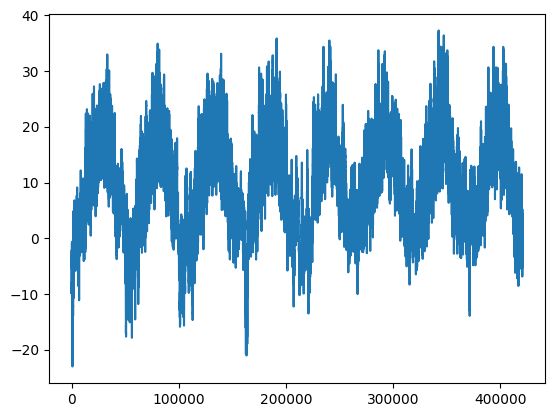

In [3]:
from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature)

**Plotting the first 10 days of the temperature timeseries**

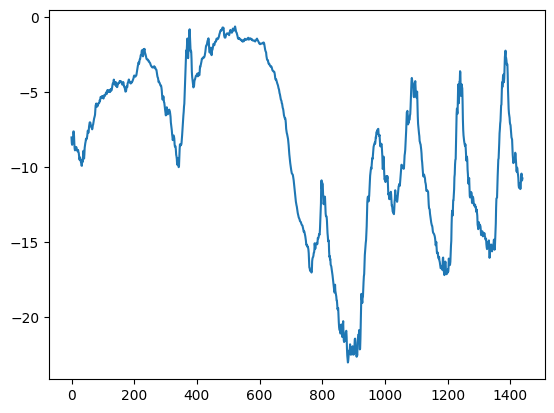

In [4]:
plt.plot(range(1440), temperature[:1440])

**Computing the number of samples we’ll use for each data split**

In [5]:
num_train_samples = int(0.5 * len(raw_data)) 
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples

print("num_train_samples:", num_train_samples) 
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


**Normalizing the data**

In [6]:
mean = raw_data[:num_train_samples].mean(axis=0) 
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0) 
raw_data /= std

**Instantiating datasets for training, validation, and testing**

In [7]:
from tensorflow import keras

sampling_rate = 6 
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1) 
batch_size = 256
train_dataset = keras.utils.timeseries_dataset_from_array( 
    raw_data[:-delay],
    targets=temperature[delay:], 
    sampling_rate=sampling_rate, 
    sequence_length=sequence_length, 
    shuffle=True,
    batch_size=batch_size, 
    start_index=0,
    end_index=num_train_samples)
val_dataset = keras.utils.timeseries_dataset_from_array( 
    raw_data[:-delay],
    targets=temperature[delay:], 
    sampling_rate=sampling_rate, 
    sequence_length=sequence_length, 
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)
test_dataset = keras.utils.timeseries_dataset_from_array( 
    raw_data[:-delay],
    targets=temperature[delay:], 
    sampling_rate=sampling_rate, 
    sequence_length=sequence_length, 
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-11-07 20:19:47.250254: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-11-07 20:19:47.250366: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


**Inspecting the output of one of our datasets**

In [8]:
for samples, targets in train_dataset:
    print("samples shape:", samples.shape) 
    print("targets shape:", targets.shape)
    break

samples shape: (256, 120, 14)
targets shape: (256,)


2023-11-07 20:19:50.256415: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


**Computing the common-sense baseline MAE**

In [9]:
def evaluate_naive_method(dataset): 
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1] 
        total_abs_err += np.sum(np.abs(preds - targets)) 
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}") 
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 2.44
Test MAE: 2.62


**Training and evaluating a densely connected model**

In [11]:
from tensorflow import keras 
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1])) 
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x) 
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs) 
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras", 
                                    save_best_only=True) 
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"]) 
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset, 
                    callbacks=callbacks)
model = keras.models.load_model("jena_dense.keras") 
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10


2023-11-07 17:16:59.174262: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


819/819 [==============================] - ETA: 0s - loss: 12.6417 - mae: 2.7501

2023-11-07 17:17:10.480727: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


819/819 [==============================] - 17s 20ms/step - loss: 12.6417 - mae: 2.7501 - val_loss: 12.6170 - val_mae: 2.8159
Epoch 2/10
819/819 [==============================] - 15s 18ms/step - loss: 9.1860 - mae: 2.3826 - val_loss: 14.8431 - val_mae: 3.0768
Epoch 3/10
819/819 [==============================] - 20s 25ms/step - loss: 8.3740 - mae: 2.2729 - val_loss: 10.5757 - val_mae: 2.5670
Epoch 4/10
819/819 [==============================] - 14s 18ms/step - loss: 7.8897 - mae: 2.2052 - val_loss: 10.6699 - val_mae: 2.5796
Epoch 5/10
819/819 [==============================] - 15s 18ms/step - loss: 7.5648 - mae: 2.1586 - val_loss: 11.6906 - val_mae: 2.7041
Epoch 6/10
819/819 [==============================] - 14s 17ms/step - loss: 7.2968 - mae: 2.1217 - val_loss: 13.1967 - val_mae: 2.8848
Epoch 7/10
819/819 [==============================] - 15s 18ms/step - loss: 7.1143 - mae: 2.0965 - val_loss: 11.9325 - val_mae: 2.7389
Epoch 8/10
819/819 [==============================] - 15s 18ms/st

2023-11-07 17:19:32.886373: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


405/405 [==============================] - 5s 12ms/step - loss: 11.3183 - mae: 2.6469
Test MAE: 2.65


**Plotting results**

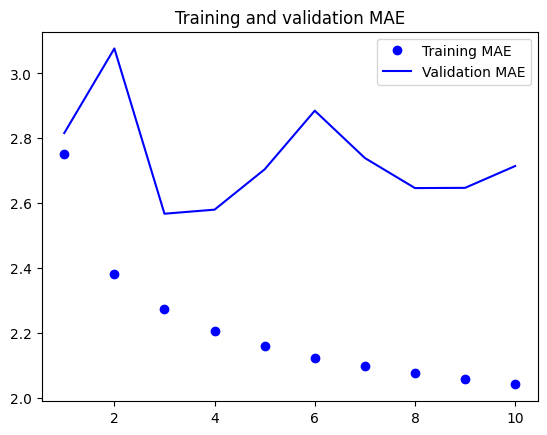

In [12]:
import matplotlib.pyplot as plt 
loss = history.history["mae"]
val_loss = history.history["val_mae"] 
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

**Try a 1D convolutional model**

In [13]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1])) 
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x) 
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x) 
x = layers.GlobalAveragePooling1D()(x) 
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs) 
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.keras", 
                                    save_best_only=True) 
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"]) 
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset, 
                    callbacks=callbacks)
model = keras.models.load_model("jena_conv.keras") 
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10


2023-11-07 17:19:38.197680: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


819/819 [==============================] - ETA: 0s - loss: 22.9383 - mae: 3.7108

2023-11-07 17:19:52.392509: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


819/819 [==============================] - 19s 22ms/step - loss: 22.9383 - mae: 3.7108 - val_loss: 15.3753 - val_mae: 3.0813
Epoch 2/10
819/819 [==============================] - 18s 22ms/step - loss: 15.1954 - mae: 3.0875 - val_loss: 17.9083 - val_mae: 3.3734
Epoch 3/10
819/819 [==============================] - 18s 22ms/step - loss: 13.9498 - mae: 2.9556 - val_loss: 14.2025 - val_mae: 2.9656
Epoch 4/10
819/819 [==============================] - 18s 22ms/step - loss: 13.0722 - mae: 2.8574 - val_loss: 14.6361 - val_mae: 3.0080
Epoch 5/10
819/819 [==============================] - 19s 23ms/step - loss: 12.3514 - mae: 2.7743 - val_loss: 15.1357 - val_mae: 3.0443
Epoch 6/10
819/819 [==============================] - 18s 22ms/step - loss: 11.8004 - mae: 2.7074 - val_loss: 16.2922 - val_mae: 3.1730
Epoch 7/10
819/819 [==============================] - 18s 22ms/step - loss: 11.4127 - mae: 2.6598 - val_loss: 18.4712 - val_mae: 3.3490
Epoch 8/10
819/819 [==============================] - 18s 2

2023-11-07 17:22:42.347851: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


405/405 [==============================] - 5s 12ms/step - loss: 14.5470 - mae: 3.0276
Test MAE: 3.03


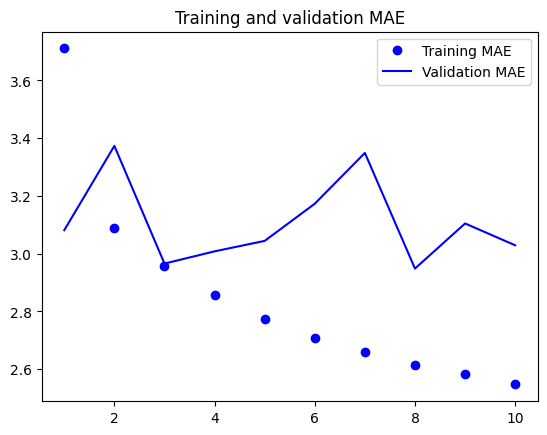

In [14]:
import matplotlib.pyplot as plt 
loss = history.history["mae"]
val_loss = history.history["val_mae"] 
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

**Try a simple LSTM-based model**

In [15]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1])) 
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs) 
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras", 
                                    save_best_only=True) 
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"]) 
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset, 
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm.keras") 
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10


2023-11-07 17:22:48.027902: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-11-07 17:22:48.305255: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-11-07 17:22:49.440101: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


819/819 [==============================] - ETA: 0s - loss: 43.0750 - mae: 4.7957

2023-11-07 17:23:19.113224: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-11-07 17:23:19.306384: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


819/819 [==============================] - 40s 46ms/step - loss: 43.0750 - mae: 4.7957 - val_loss: 13.0143 - val_mae: 2.7404
Epoch 2/10
819/819 [==============================] - 35s 43ms/step - loss: 11.1247 - mae: 2.5931 - val_loss: 9.9869 - val_mae: 2.4699
Epoch 3/10
819/819 [==============================] - 37s 45ms/step - loss: 9.8534 - mae: 2.4545 - val_loss: 9.9321 - val_mae: 2.4483
Epoch 4/10
819/819 [==============================] - 35s 43ms/step - loss: 9.4735 - mae: 2.4072 - val_loss: 10.8439 - val_mae: 2.4936
Epoch 5/10
819/819 [==============================] - 36s 44ms/step - loss: 9.1854 - mae: 2.3690 - val_loss: 11.8344 - val_mae: 2.5417
Epoch 6/10
819/819 [==============================] - 36s 44ms/step - loss: 8.9383 - mae: 2.3350 - val_loss: 10.2953 - val_mae: 2.4503
Epoch 7/10
819/819 [==============================] - 35s 43ms/step - loss: 8.7895 - mae: 2.3133 - val_loss: 10.0854 - val_mae: 2.4398
Epoch 8/10
819/819 [==============================] - 36s 43ms/ste

2023-11-07 17:28:49.086271: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-11-07 17:28:49.254441: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


405/405 [==============================] - 9s 21ms/step - loss: 11.2517 - mae: 2.6265
Test MAE: 2.63


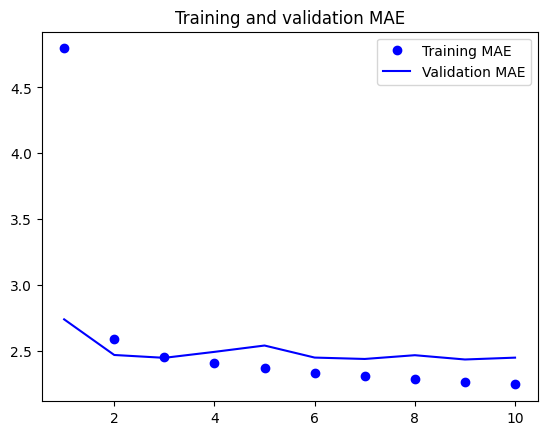

In [16]:
import matplotlib.pyplot as plt 
loss = history.history["mae"]
val_loss = history.history["val_mae"] 
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

### Additional Experiments

#### 1) Bidirectional LSTM 모델 적용

In [17]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1])) 
x = layers.Bidirectional(layers.LSTM(16))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs) 
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_Bidirectional_lstm.x", 
                                    save_best_only=True) 
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"]) 
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset, 
                    callbacks=callbacks)

model = keras.models.load_model("jena_Bidirectional_lstm.x") 
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10


2023-11-07 17:28:58.980158: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-11-07 17:28:59.383970: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-11-07 17:28:59.384011: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-11-07 17:28:59.660184: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-11-07 17:28:59.682478: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


819/819 [==============================] - ETA: 0s - loss: 28.6006 - mae: 3.8174

2023-11-07 17:29:46.845170: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-11-07 17:29:47.055658: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-11-07 17:29:47.055830: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: jena_Bidirectional_lstm.x/assets


INFO:tensorflow:Assets written to: jena_Bidirectional_lstm.x/assets


819/819 [==============================] - 66s 79ms/step - loss: 28.6006 - mae: 3.8174 - val_loss: 10.1395 - val_mae: 2.4607
Epoch 2/10
819/819 [==============================] - ETA: 0s - loss: 9.4778 - mae: 2.4015

INFO:tensorflow:Assets written to: jena_Bidirectional_lstm.x/assets


INFO:tensorflow:Assets written to: jena_Bidirectional_lstm.x/assets


819/819 [==============================] - 63s 77ms/step - loss: 9.4778 - mae: 2.4015 - val_loss: 9.8345 - val_mae: 2.4212
Epoch 3/10
819/819 [==============================] - 60s 73ms/step - loss: 8.5455 - mae: 2.2778 - val_loss: 10.0175 - val_mae: 2.4513
Epoch 4/10
819/819 [==============================] - 59s 72ms/step - loss: 7.9490 - mae: 2.1955 - val_loss: 10.4707 - val_mae: 2.5117
Epoch 5/10
819/819 [==============================] - 59s 72ms/step - loss: 7.5680 - mae: 2.1385 - val_loss: 10.9841 - val_mae: 2.5682
Epoch 6/10
819/819 [==============================] - 59s 72ms/step - loss: 7.2192 - mae: 2.0879 - val_loss: 10.3683 - val_mae: 2.4904
Epoch 7/10
819/819 [==============================] - 59s 72ms/step - loss: 6.9517 - mae: 2.0490 - val_loss: 10.2045 - val_mae: 2.4695
Epoch 8/10
819/819 [==============================] - 59s 72ms/step - loss: 6.7240 - mae: 2.0137 - val_loss: 10.3798 - val_mae: 2.4943
Epoch 9/10
819/819 [==============================] - 59s 72ms/step

2023-11-07 17:39:05.197303: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-11-07 17:39:05.410859: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-11-07 17:39:05.410974: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


405/405 [==============================] - 15s 35ms/step - loss: 10.3388 - mae: 2.5303
Test MAE: 2.53


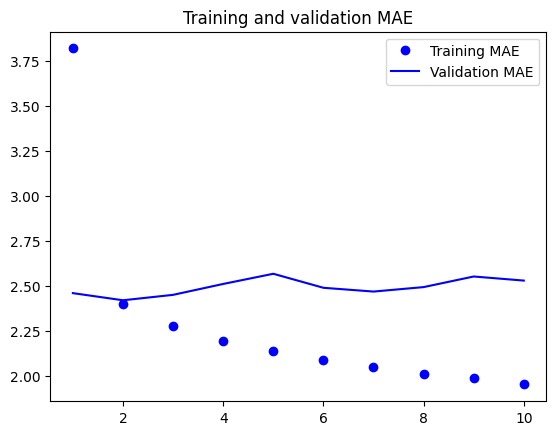

In [18]:
import matplotlib.pyplot as plt 
loss = history.history["mae"]
val_loss = history.history["val_mae"] 
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

#### 2) GRU 모델 적용

In [12]:
x = layers.GRU(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs) 
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras", 
                                    save_best_only=True) 
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"]) 
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset, 
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm.keras") 
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10


2023-11-07 20:25:10.369026: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-11-07 20:25:10.664341: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-11-07 20:25:11.105005: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


819/819 [==============================] - ETA: 0s - loss: 44.9571 - mae: 5.0470

2023-11-07 20:25:46.304484: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-11-07 20:25:46.501490: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


819/819 [==============================] - 45s 51ms/step - loss: 44.9571 - mae: 5.0470 - val_loss: 18.4638 - val_mae: 3.3063
Epoch 2/10
819/819 [==============================] - 42s 51ms/step - loss: 15.3937 - mae: 3.0901 - val_loss: 14.2184 - val_mae: 2.9125
Epoch 3/10
819/819 [==============================] - 41s 51ms/step - loss: 13.2399 - mae: 2.8699 - val_loss: 12.8888 - val_mae: 2.7818
Epoch 4/10
819/819 [==============================] - 40s 49ms/step - loss: 12.3690 - mae: 2.7674 - val_loss: 12.8130 - val_mae: 2.7793
Epoch 5/10
819/819 [==============================] - 40s 49ms/step - loss: 12.0493 - mae: 2.7300 - val_loss: 12.7509 - val_mae: 2.7604
Epoch 6/10
819/819 [==============================] - 40s 49ms/step - loss: 11.7842 - mae: 2.6988 - val_loss: 12.9678 - val_mae: 2.7725
Epoch 7/10
819/819 [==============================] - 40s 49ms/step - loss: 11.5020 - mae: 2.6679 - val_loss: 12.7100 - val_mae: 2.7518
Epoch 8/10
819/819 [==============================] - 40s 4

2023-11-07 20:31:59.190930: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-11-07 20:31:59.362251: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


405/405 [==============================] - 9s 21ms/step - loss: 13.5982 - mae: 2.9041
Test MAE: 2.90


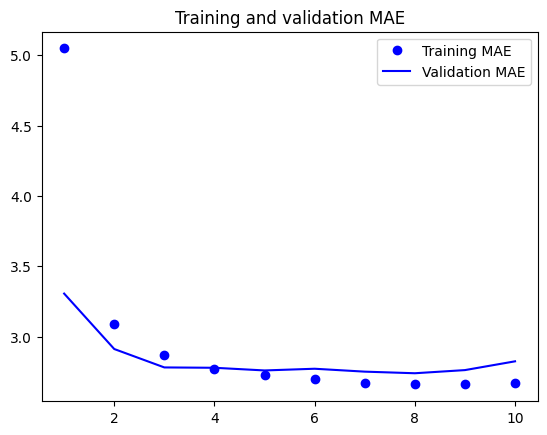

In [13]:
import matplotlib.pyplot as plt 
loss = history.history["mae"]
val_loss = history.history["val_mae"] 
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()